In [5]:
# Decide whether or not running on Kaggle
import os
KAGGLE_RUN = True
if os.path.isdir('/home/ubuntu'):
    KAGGLE_RUN = False

import sys
import pandas as pd
import numpy as np
import gc
from sklearn.metrics import roc_auc_score
from collections import defaultdict
import lightgbm as lgb
import datatable as dt
import json
import time
import pickle
import dill

if not KAGGLE_RUN:
    sys.path.insert(0, './input')
    import local_work
    
import riiideducation

# Boto3 Setup and Download Files
if not KAGGLE_RUN:
    local_work = local_work.local_work()
    local_work.download_riiid_files()

import random
import os


In [6]:
def get_questions(KAGGLE_RUN):
    # Load questions
    if not KAGGLE_RUN:
        questions_df = local_work.get_questions_data()
        question_cmnts = pd.read_csv('./input/question_cmnts_v5.csv')
    else:   
        questions_df = pd.read_csv('../input/riiid-test-answer-prediction/questions.csv')
        question_cmnts = pd.read_csv('../input/question-cmnts-v5/question_cmnts_v5.csv')
        
    # Add Communities to questions
    question_cmnts.columns = ['question_id', 'community']
    questions_df = questions_df.merge(question_cmnts, on = 'question_id', how = 'left')
    
    # Get tags of questions
    inv_rows = questions_df[questions_df['tags'].apply(type) == float].index
    questions_df.at[inv_rows, 'tags'] = ''
    questions_df['tags'] = questions_df['tags'].apply(lambda x: np.array(x.split()).astype(int))
    questions_df['n_tags'] = questions_df['tags'].str.len()
    questions_df.loc[questions_df.n_tags == 0, 'n_tags'] = 1
    questions_df['tag_1'] = questions_df['tags'].map(lambda x: x[0] if len(x) > 0 else np.nan)
    questions_df['tag_2'] = questions_df['tags'].map(lambda x: x[1] if len(x) > 1 else np.nan)
    questions_df['tag_3'] = questions_df['tags'].map(lambda x: x[2] if len(x) > 2 else np.nan)
        
    # Change questions dtypes
    questions_df['part'] = questions_df['part'].astype(np.int32)
    questions_df['bundle_id'] = questions_df['bundle_id'].astype(np.int32)
    questions_df['community'] = questions_df['community'].astype(np.int8)
    
    return(questions_df)

def get_cond_probs(KAGGLE_RUN):
    # Load conditional probabilities
    if KAGGLE_RUN:
        with open('../input/finalmodels/cond_probs.pickle', 'rb') as handle:
            cond_probs =  pickle.load(handle)
    else:
        with open('./output/cond_probs.pickle', 'rb') as handle:
            cond_probs =  pickle.load(handle)
    return(cond_probs)

# Funcion for user stats with loops
def add_features(df, features_dicts, cond_probs, KAGGLE_RUN, is_inference):
    
            
    # -----------------------------------------------------------------------
    # Get feature dicts
    d_answered_correctly_u_count = features_dicts['d_answered_correctly_u_count']
    d_answered_correctly_u_sum = features_dicts['d_answered_correctly_u_sum']
    d_answered_correctly_prev10_u = features_dicts['d_answered_correctly_prev10_u']
    d_elapsed_time_u_sum = features_dicts['d_elapsed_time_u_sum']
    d_explanation_u_sum = features_dicts['d_explanation_u_sum']
    d_answered_correctly_q_count = features_dicts['d_answered_correctly_q_count']
    d_answered_correctly_q_sum = features_dicts['d_answered_correctly_q_sum']
    d_elapsed_time_q_sum = features_dicts['d_elapsed_time_q_sum']
    d_explanation_ac_q_count = features_dicts['d_explanation_ac_q_count']
    d_answered_correctly_uq = features_dicts['d_answered_correctly_uq']
    d_timestamp_u = features_dicts['d_timestamp_u']
    d_timestamp_u_incorrect = features_dicts['d_timestamp_u_incorrect']
    d_answered_correctly_up_sum = features_dicts['d_answered_correctly_up_sum']
    d_answered_correctly_up_count = features_dicts['d_answered_correctly_up_count']
    d_answered_correctly_uc_count = features_dicts['d_answered_correctly_uc_count']
    d_answered_correctly_uc_sum = features_dicts['d_answered_correctly_uc_sum']
    d_answered_correctly_ut_count = features_dicts['d_answered_correctly_ut_count']
    d_answered_correctly_ut_sum = features_dicts['d_answered_correctly_ut_sum']
    d_lectures_u_count = features_dicts['d_lectures_u_count']
    d_uq_prev = features_dicts['d_uq_prev']
    
    
    # -----------------------------------------------------------------------
    # Client features
    answered_correctly_u_avg = np.zeros(len(df), dtype = np.float32)
    answered_correctly_prev10_u_avg = np.zeros(len(df), dtype = np.float32)
    answered_correctly_prev5_u_avg = np.zeros(len(df), dtype = np.float32)
    elapsed_time_u_avg = np.zeros(len(df), dtype = np.float32)
    explanation_u_avg = np.zeros(len(df), dtype = np.float32)
    timestamp_u_recency_1 = np.zeros(len(df), dtype = np.float32)
    timestamp_u_recency_2 = np.zeros(len(df), dtype = np.float32)
    timestamp_u_recency_3 = np.zeros(len(df), dtype = np.float32)
    timestamp_u_incorrect_recency = np.zeros(len(df), dtype = np.float32)
    
    lectures_u_count = np.zeros(len(df), dtype = np.int32)
    # -----------------------------------------------------------------------
    # Question features
    answered_correctly_q_avg = np.zeros(len(df), dtype = np.float32)
    elapsed_time_q_avg = np.zeros(len(df), dtype = np.float32)
    explanation_q_avg = np.zeros(len(df), dtype = np.float32)
    # -----------------------------------------------------------------------
    # User Question
    answered_correctly_uq_count = np.zeros(len(df), dtype = np.int32)
    # -----------------------------------------------------------------------
    # User Part
    answered_correctly_up_count = np.zeros(len(df), dtype = np.int32)
    answered_correctly_up_avg = np.zeros(len(df), dtype = np.float32)
    # -----------------------------------------------------------------------
    # User Community
    answered_correctly_uc_count = np.zeros(len(df), dtype = np.int32)
    answered_correctly_uc_avg = np.zeros(len(df), dtype = np.float32)    
    # -----------------------------------------------------------------------
    # User Tags
    answered_correctly_ut_cum_count = np.zeros(len(df), dtype = np.int32)
    answered_correctly_ut_cum_sum = np.zeros(len(df), dtype = np.int)
    answered_correctly_ut_cum_avg = np.zeros(len(df), dtype = np.float)
    # -----------------------------------------------------------------------
    # User Questions
    cond_uq_prob = np.zeros(len(df), dtype = np.float)
    
    # -----------------------------------------------------------------------
    
    
    
    DF_NROW = df.shape[0]
    for num, row in enumerate(df[['user_id'
                                  ,'answered_correctly'
                                  ,'content_id'
                                  ,'prior_question_elapsed_time'
                                  ,'prior_question_had_explanation'
                                  ,'timestamp'
                                  ,'part'
                                  ,'community'
                                  ,'tags' 
                                  ,'content_type_id' # 9
                                 ]].values):
        
        if DF_NROW > 5000000 and not KAGGLE_RUN:
            if num % 10000000 == 0:
                print('Progress: ' + str(round(num/DF_NROW, 3)))
                
        if row[9] == 1:
            # Lecture updates
            # ------------------------------------------------------------------
            d_lectures_u_count[row[0]] += 1
            
        else:
            # Client features assignation
            # ------------------------------------------------------------------
            if d_answered_correctly_u_count[row[0]] != 0:
                answered_correctly_u_avg[num] = d_answered_correctly_u_sum[row[0]] /\
                                                    d_answered_correctly_u_count[row[0]]
                elapsed_time_u_avg[num] = d_elapsed_time_u_sum[row[0]] / d_answered_correctly_u_count[row[0]]
                explanation_u_avg[num] = d_explanation_u_sum[row[0]] / d_answered_correctly_u_count[row[0]]
            else:
                answered_correctly_u_avg[num] = np.nan
                elapsed_time_u_avg[num] = np.nan
                explanation_u_avg[num] = np.nan

            if len(d_timestamp_u[row[0]]) == 0:
                timestamp_u_recency_1[num] = np.nan
                timestamp_u_recency_2[num] = np.nan
                timestamp_u_recency_3[num] = np.nan
            elif len(d_timestamp_u[row[0]]) == 1:
                timestamp_u_recency_1[num] = row[5] - d_timestamp_u[row[0]][0]
                timestamp_u_recency_2[num] = np.nan
                timestamp_u_recency_3[num] = np.nan
            elif len(d_timestamp_u[row[0]]) == 2:
                timestamp_u_recency_1[num] = row[5] - d_timestamp_u[row[0]][1]
                timestamp_u_recency_2[num] = row[5] - d_timestamp_u[row[0]][0]
                timestamp_u_recency_3[num] = np.nan
            elif len(d_timestamp_u[row[0]]) == 3:
                timestamp_u_recency_1[num] = row[5] - d_timestamp_u[row[0]][2]
                timestamp_u_recency_2[num] = row[5] - d_timestamp_u[row[0]][1]
                timestamp_u_recency_3[num] = row[5] - d_timestamp_u[row[0]][0]

            if len(d_timestamp_u_incorrect[row[0]]) == 0:
                timestamp_u_incorrect_recency[num] = np.nan
            else:
                timestamp_u_incorrect_recency[num] = row[5] - d_timestamp_u_incorrect[row[0]][0]

            # prev10 and prev5 will behave a little differently in the beginning
            if len(d_answered_correctly_prev10_u[row[0]]) == 0:
                answered_correctly_prev10_u_avg[num] = np.nan
            else:
                answered_correctly_prev10_u_avg[num] = sum(d_answered_correctly_prev10_u[row[0]])/\
                                                        len(d_answered_correctly_prev10_u[row[0]])
            if len(d_answered_correctly_prev10_u[row[0]]) > 5:
                answered_correctly_prev5_u_avg[num] = sum(d_answered_correctly_prev10_u[row[0]][-5:])/5
            else:
                answered_correctly_prev5_u_avg[num] = np.nan
                
            # Lecture assignation
            lectures_u_count[num] = d_lectures_u_count[row[0]]

            # ------------------------------------------------------------------
            # Question features assignation
            if d_answered_correctly_q_count[row[2]] != 0:
                answered_correctly_q_avg[num] = d_answered_correctly_q_sum[row[2]] / d_answered_correctly_q_count[row[2]]
                elapsed_time_q_avg[num] = d_elapsed_time_q_sum[row[2]] / d_answered_correctly_q_count[row[2]]
                explanation_q_avg[num] = d_explanation_ac_q_count[row[2]] / d_answered_correctly_q_count[row[2]]
            else:
                answered_correctly_q_avg[num] = np.nan
                elapsed_time_q_avg[num] = np.nan
                explanation_q_avg[num] = np.nan

            # ------------------------------------------------------------------
            # Client Question assignation
            answered_correctly_uq_count[num] = d_answered_correctly_uq[row[0]][row[2]]

            # ------------------------------------------------------------------
            # Client Part assignation
            answered_correctly_up_count[num] = d_answered_correctly_up_count[row[0]][row[6]]
            if d_answered_correctly_up_count[row[0]][row[6]] == 0:
                answered_correctly_up_avg[num] = np.nan
            else:
                answered_correctly_up_avg[num] = d_answered_correctly_up_sum[row[0]][row[6]] /\
                                                    d_answered_correctly_up_count[row[0]][row[6]]
            # ------------------------------------------------------------------
            # Client Community assignation
            answered_correctly_uc_count[num] = d_answered_correctly_uc_count[row[0]][row[7]]
            if d_answered_correctly_uc_count[row[0]][row[7]] == 0:
                answered_correctly_uc_avg[num] = np.nan
            else:
                answered_correctly_uc_avg[num] = d_answered_correctly_uc_sum[row[0]][row[7]] /\
                                                    d_answered_correctly_uc_count[row[0]][row[7]]  

            # ------------------------------------------------------------------
            # Client Tag assignation
            for t in row[8]:
                answered_correctly_ut_cum_count[num] += d_answered_correctly_ut_count[row[0]][t]
                answered_correctly_ut_cum_sum[num] += d_answered_correctly_ut_sum[row[0]][t]

            if answered_correctly_ut_cum_count[num] == 0:
                answered_correctly_ut_cum_avg[num] = np.nan
            else:
                answered_correctly_ut_cum_avg[num] = answered_correctly_ut_cum_sum[num] /\
                                                        answered_correctly_ut_cum_count[num]   
                
            # ------------------------------------------------------------------
            # Client question assignation
            if False:
                # If this is a question we have engineered
                if row[2] in cond_probs['content_id_keys'].keys():

                    # If the user has answered the corresponding previous question
                    tmp_idx = cond_probs['content_id_keys'][row[2]]
                    tmp_prev_id = cond_probs['content_id_prev'][tmp_idx]
                    if tmp_prev_id in d_uq_prev[row[0]].keys():

                        # Assign the associated probability
                        tmp_prev_ac = d_uq_prev[row[0]][tmp_prev_id]
                        if tmp_prev_ac == 0:
                            cond_uq_prob[num] = cond_probs['prev_wrong_current_mean'][tmp_idx]
                        elif tmp_prev_ac == 1:
                            cond_uq_prob[num] = cond_probs['prev_right_current_mean'][tmp_idx]
                        elif tmp_prev_ac == -1:
                            cond_uq_prob[num] = np.nan
                            print('Unexpected output in Client Question Assignation')
                            print(tmp_idx)
                            print(tmp_prev_id)
                            print(tmp_prev_ac)                                            
                    else:
                        cond_uq_prob[num] = np.nan
                else:
                    cond_uq_prob[num] = np.nan
                

            # ------------------------------------------------------------------
            # ------------------------------------------------------------------
            # Client features updates
            d_answered_correctly_u_count[row[0]] += 1
            d_elapsed_time_u_sum[row[0]] += row[3]
            d_explanation_u_sum[row[0]] += int(row[4])
            if len(d_timestamp_u[row[0]]) == 3:
                d_timestamp_u[row[0]].pop(0)
            d_timestamp_u[row[0]].append(row[5])
            # ------------------------------------------------------------------
            # Question features updates
            d_answered_correctly_q_count[row[2]] += 1
            d_elapsed_time_q_sum[row[2]] += row[3]
            d_explanation_ac_q_count[row[2]] += int(row[4])
            # ------------------------------------------------------------------
            # Client Question updates
            d_answered_correctly_uq[row[0]][row[2]] += 1
            # ------------------------------------------------------------------
            # Client Part updates
            d_answered_correctly_up_count[row[0]][row[6]] += 1 
            # ------------------------------------------------------------------
            # Client Community updates
            d_answered_correctly_uc_count[row[0]][row[7]] += 1    
            # ------------------------------------------------------------------
            # Client Tag updates
            for t in row[8]:
                d_answered_correctly_ut_count[row[0]][t] += 1            

            # ------------------------------------------------------------------
            # Flag for training and inference. Note: this is almost identical to update_features()
            if not is_inference:
                # ------------------------------------------------------------------
                # Client question updates
                if False:
                    if row[2] in cond_probs['content_id_prev']:
                        if d_uq_prev[row[0]][row[2]] == -1: # User has not answered question                    
                            d_uq_prev[row[0]][row[2]] = row[1]

                # ------------------------------------------------------------------
                # Client features updates
                d_answered_correctly_u_sum[row[0]] += row[1]
                if row[1] == 0:
                    if len(d_timestamp_u_incorrect[row[0]]) == 1:
                        d_timestamp_u_incorrect[row[0]].pop(0)
                    d_timestamp_u_incorrect[row[0]].append(row[5])

                if len(d_answered_correctly_prev10_u[row[0]]) == 10:
                    d_answered_correctly_prev10_u[row[0]].pop(0)
                d_answered_correctly_prev10_u[row[0]].append(row[1])                

                # ------------------------------------------------------------------
                # Question features updates
                d_answered_correctly_q_sum[row[2]] += row[1]

                # ------------------------------------------------------------------
                # Client Part features updates
                d_answered_correctly_up_sum[row[0]][row[6]] += row[1]

                # ------------------------------------------------------------------
                # Client Community features updates
                d_answered_correctly_uc_sum[row[0]][row[7]] += row[1]
                
                # ------------------------------------------------------------------
                # Client Community tag updates                
                for t in row[8]:
                    d_answered_correctly_ut_sum[row[0]][t] += row[1]                 

                # ------------------------------------------------------------------
             
    # END FOR LOOP
    
    user_df = pd.DataFrame({'answered_correctly_u_avg': answered_correctly_u_avg
                            ,'elapsed_time_u_avg': elapsed_time_u_avg
                            ,'explanation_u_avg': explanation_u_avg
                            ,'answered_correctly_q_avg': answered_correctly_q_avg
                            ,'answered_correctly_prev10_u_avg': answered_correctly_prev10_u_avg
                            ,'answered_correctly_prev5_u_avg': answered_correctly_prev5_u_avg
                            ,'elapsed_time_q_avg': elapsed_time_q_avg
                            ,'explanation_q_avg': explanation_q_avg
                            ,'answered_correctly_uq_count': answered_correctly_uq_count
                            ,'timestamp_u_recency_1': timestamp_u_recency_1
                            ,'timestamp_u_recency_2': timestamp_u_recency_2
                            ,'timestamp_u_recency_3': timestamp_u_recency_3
                            ,'timestamp_u_incorrect_recency': timestamp_u_incorrect_recency
                            ,'answered_correctly_up_avg' : answered_correctly_up_avg
                            ,'answered_correctly_up_count' : answered_correctly_up_count
                            ,'answered_correctly_uc_avg' : answered_correctly_uc_avg
                            ,'answered_correctly_uc_count' : answered_correctly_uc_count
                            ,'answered_correctly_ut_cum_count' : answered_correctly_ut_cum_count 
                            ,'answered_correctly_ut_cum_avg' : answered_correctly_ut_cum_avg
                            ,'lectures_u_count' : lectures_u_count
                            #,'cond_uq_prob' : cond_uq_prob
                           })
    
    # Only need to concat rows if building a model or inferring
    if (not KAGGLE_RUN) or is_inference:
        df = pd.concat([df, user_df], axis = 1)
        
    # Return
    return df
        
def update_features(df, features_dicts, cond_probs):
    # -----------------------------------------------------------------------
    # Get feature dicts
    d_answered_correctly_u_sum = features_dicts['d_answered_correctly_u_sum']
    d_answered_correctly_q_sum = features_dicts['d_answered_correctly_q_sum']
    d_timestamp_u_incorrect = features_dicts['d_timestamp_u_incorrect']
    d_answered_correctly_prev10_u = features_dicts['d_answered_correctly_prev10_u']
    d_answered_correctly_up_sum = features_dicts['d_answered_correctly_up_sum']
    d_answered_correctly_uc_sum = features_dicts['d_answered_correctly_uc_sum']
    d_answered_correctly_ut_sum = features_dicts['d_answered_correctly_ut_sum']
    d_uq_prev = features_dicts['d_uq_prev']
    
    for row in df[['user_id'
                   ,'answered_correctly'
                   ,'content_id'
                   ,'content_type_id'
                   ,'timestamp'
                   ,'part'
                   ,'community'
                   ,'tags' # 7
                  ]].values:
        if row[3] == 0:
            # ------------------------------------------------------------------
            if False:
            # Client question updates
                if row[2] in cond_probs['content_id_prev']:
                    if d_uq_prev[row[0]][row[2]] == -1: # User has not answered question                    
                        d_uq_prev[row[0]][row[2]] = row[1]
            # ------------------------------------------------------------------
            # Client features updates
            d_answered_correctly_u_sum[row[0]] += row[1]
            if row[1] == 0:
                if len(d_timestamp_u_incorrect[row[0]]) == 1:
                    d_timestamp_u_incorrect[row[0]].pop(0)
                d_timestamp_u_incorrect[row[0]].append(row[4])
                
            if len(d_answered_correctly_prev10_u[row[0]]) == 10:
                d_answered_correctly_prev10_u[row[0]].pop(0)
            d_answered_correctly_prev10_u[row[0]].append(row[1])                   
            # ------------------------------------------------------------------
            # Question features updates
            d_answered_correctly_q_sum[row[2]] += row[1]
            
            # ------------------------------------------------------------------
            # Client Part features updates
            d_answered_correctly_up_sum[row[0]][row[5]] += row[1]
            
            # ------------------------------------------------------------------
            # Client Community features updates
            d_answered_correctly_uc_sum[row[0]][row[6]] += row[1]
            
            # ------------------------------------------------------------------
            # Client Community tag updates  
            for t in row[7]:
                d_answered_correctly_ut_sum[row[0]][t] += row[1]               

def read_and_preprocess(KAGGLE_RUN, final_params):

    # Make feature_dicts dictionary for easy passing between functions
    features_dicts = {
        # Client dictionaries
        'd_answered_correctly_u_count': defaultdict(int)
        ,'d_answered_correctly_u_sum': defaultdict(int)
        ,'d_answered_correctly_prev10_u': defaultdict(list)
        ,'d_elapsed_time_u_sum': defaultdict(int)
        ,'d_explanation_u_sum': defaultdict(int)
        ,'d_timestamp_u': defaultdict(list)
        ,'d_timestamp_u_incorrect': defaultdict(list)
        ,'d_lectures_u_count': defaultdict(int)
        
        # Question Dictionaries
        ,'d_answered_correctly_q_count': defaultdict(int)
        ,'d_answered_correctly_q_sum': defaultdict(int)
        ,'d_elapsed_time_q_sum': defaultdict(int)
        ,'d_explanation_ac_q_count': defaultdict(int)
        
        # Client Question dictionary (how many times has the client seen the question)
        ,'d_answered_correctly_uq': defaultdict(lambda: defaultdict(int))
        
        # Client Part dictionary
        ,'d_answered_correctly_up_count': defaultdict(lambda: defaultdict(int))
        ,'d_answered_correctly_up_sum': defaultdict(lambda: defaultdict(int))
        
        # Client Community Dictionary
        ,'d_answered_correctly_uc_count': defaultdict(lambda: defaultdict(int))
        ,'d_answered_correctly_uc_sum' : defaultdict(lambda: defaultdict(int))
        
        # Client Tag Dictionary
        ,'d_answered_correctly_ut_count': defaultdict(lambda: defaultdict(int))
        ,'d_answered_correctly_ut_sum': defaultdict(lambda: defaultdict(int))
        
        # Previous questions dictionaries
        ,'d_uq_prev' : defaultdict(lambda: defaultdict(lambda: int(-1))) #{user_id : {question_id : ac}}
    }
    
    # Load questions and cond_probs
    questions_df = get_questions(KAGGLE_RUN)
    cond_probs = get_cond_probs(KAGGLE_RUN)
        
    # Need to load all columns when batching
    train_cols = ['row_id', 'timestamp', 'user_id', 'content_id', 'content_type_id',
               'task_container_id', 'user_answer', 'answered_correctly',
               'prior_question_elapsed_time', 'prior_question_had_explanation']
    
    # Columns we need
    feld_needed = ['timestamp'
                   ,'user_id'
                   ,'answered_correctly'
                   ,'content_id'
                   ,'content_type_id'
                   ,'prior_question_elapsed_time'
                   ,'prior_question_had_explanation'
                  ]
    total_train_count = 0
    for i in range(final_params['n_kaggle_loops']):
        if not KAGGLE_RUN:
            train = dt.fread('./input/train.csv'
                            ,skip_to_line = final_params['n_skip_rows']
                            ,max_nrows = final_params['N_TRAIN_ROWS']
                            ).to_pandas()
            
        else:
            train = dt.fread('../input/riiid-test-answer-prediction/train.csv'
                            ,skip_to_line = i * 10000000 + 2
                            ,max_nrows = 10000000
                            ).to_pandas()
            

        # Needed when skipping rows
        train.columns = train_cols
        train = train[feld_needed]
        
        # Record total train count (to ensure using all rows when batching on kaggle)
        total_train_count += train.shape[0]
    
        # Filter by content_type_id to discard lectures
        #train = train.loc[train.content_type_id == 0].reset_index(drop = True)

        # No need for validation set if running on kaggle
        if not KAGGLE_RUN:
            # Make validation set
            # Add entire user histories to validation set
            tmp = train.user_id.unique()
            tmp = np.random.choice(tmp, int(.07 * tmp.shape[0]))
            valid_full = train.loc[train['user_id'].isin(tmp)]
            train.drop(valid_full.index, inplace=True)

            # Make validation the last 40 of user histories
            tmp = train.user_id.unique()
            tmp = np.random.choice(tmp, int(.15 * tmp.shape[0]))
            valid_end_40 = train.loc[train['user_id'].isin(tmp)].groupby('user_id').tail(40)
            train.drop(valid_end_40.index, inplace=True)

            # Make validation set the last 100 of user histories
            tmp = train.user_id.unique()
            tmp = np.random.choice(tmp, int(.15 * tmp.shape[0]))
            valid_end_100 = train.loc[train['user_id'].isin(tmp)].groupby('user_id').tail(100)
            train.drop(valid_end_100.index, inplace=True)   

            # Combine the sets
            print('Joining validation sets')
            valid = valid_full.append([valid_end_40, valid_end_100])
            print('Validation size: ' + str(valid.shape[0]))
            print('Train size: ' + str(train.shape[0]))
        else:
            valid = None

        # Changing dtype to avoid lightgbm error
        train['prior_question_had_explanation'] = train.prior_question_had_explanation.fillna(False).astype('int8')

        # Merge with questions dataframe
        q_cols = ['question_id', 'part', 'community', 'correct_answer', 'tags', 'n_tags'
                 ,'tag_1', 'tag_2', 'tag_3']
        train = pd.merge(train, questions_df[q_cols]
                         ,left_on = 'content_id'
                         ,right_on = 'question_id'
                         ,how = 'left')

        if not KAGGLE_RUN:
            valid['prior_question_had_explanation'] = valid.prior_question_had_explanation.fillna(False).astype('int8')
            valid = pd.merge(valid, questions_df[q_cols]
                             ,left_on = 'content_id'
                             ,right_on = 'question_id'
                             ,how = 'left')

        print('Train Feature Calculation Started - ' + str(i))
        train = add_features(train, features_dicts, cond_probs, KAGGLE_RUN = KAGGLE_RUN, is_inference = False)
        
        # Only run once for model buildling
        if not KAGGLE_RUN:
            break
    
    print('Number of training rows read: ' + str(total_train_count))
    
    # Free up space
    if KAGGLE_RUN:
        del train
        train = None
    
    # Add features for validation set
    if not KAGGLE_RUN:
        print('Valid Feature Calculation Started')
        valid = add_features(valid, features_dicts, cond_probs, KAGGLE_RUN = KAGGLE_RUN, is_inference = False)
    gc.collect()
    print('Training/Valid Garbage Collected')
    
    # Filter by content_type_id to discard lectures for modeling
    if not KAGGLE_RUN:
        train = train.loc[train.content_type_id == 0].reset_index(drop = True) 
        valid = valid.loc[valid.content_type_id == 0].reset_index(drop = True) 
    
    return train, valid, questions_df, features_dicts

# Function for training and evaluation
def train_and_evaluate(train, valid, KAGGLE_RUN, final_params):
    
    TARGET = 'answered_correctly'
    
    FEATURES = [
                'prior_question_elapsed_time'
                ,'prior_question_had_explanation'
                ,'part'
                ,'community'
                ,'answered_correctly_u_avg'
                ,'answered_correctly_prev5_u_avg'
                ,'answered_correctly_prev10_u_avg'
                ,'elapsed_time_u_avg'
                ,'explanation_u_avg'
                ,'answered_correctly_q_avg'
                ,'elapsed_time_q_avg'
                ,'explanation_q_avg'
                ,'answered_correctly_uq_count'
                ,'timestamp_u_recency_1'
                ,'timestamp_u_recency_2'
                ,'timestamp_u_recency_3'
                ,'timestamp_u_incorrect_recency'
                ,'answered_correctly_up_avg'
                ,'answered_correctly_up_count'
                ,'answered_correctly_uc_avg'
                ,'answered_correctly_uc_count'
                ,'answered_correctly_ut_cum_count'
                ,'answered_correctly_ut_cum_avg'
                ,'n_tags'
                ,'tag_1'
                ,'tag_2'
                ,'tag_3'
                ,'lectures_u_count'
                ,'correct_answer'
                ,'cond_uq_prob'
               ] # length = 30
    
    if not KAGGLE_RUN:
        # Filter out the featuers. Will be done separetely when testing
        FEATURES_i = [f for f in FEATURES if f not in final_params['dont_include']]
        
        # Continue
        print(f'Training with {train.shape[0]} rows and {len(FEATURES_i)} features')    
        d_train = lgb.Dataset(train[FEATURES_i], label=train[TARGET])
        d_valid = lgb.Dataset(valid[FEATURES_i], label=valid[TARGET])

        params = {'objective': 'binary', 
                  'seed': final_params['seed'],
                  'metric': 'auc',
                  'learning_rate': final_params['learning_rate'],
                  'num_leaves': final_params['num_leaves'],
                  'feature_fraction': final_params['feature_fraction'],
                  'bagging_fraction': final_params['bagging_fraction'],
                  'bagging_freq' : final_params['bagging_freq'],
                  'min_data_in_leaf' : final_params['min_data_in_leaf'],
                  'max_depth' : final_params['max_depth']
                 }        

        model = lgb.train(
                        params = params,
                        train_set = d_train,
                        num_boost_round = final_params['num_boost_round'],
                        valid_sets = [d_train, d_valid],
                        early_stopping_rounds = final_params['early_stopping_rounds'],
                        verbose_eval = 200
                        )
        model.save_model('./output/' + final_params['model_name'] + 'No_Cond.txt')
        lgb.plot_importance(model, importance_type='gain')
        return
    
    else:
        models = {}
        for i in final_params['models_to_use']:
            tmp = final_params['kaggle_model_path'] + final_params['models'][i]['model_name']
            models[i] = lgb.Booster(model_file =  tmp + '.txt')
        return TARGET, FEATURES, models

# Using time series api that simulates production predictions
def inference(TARGET, FEATURES, models, questions_df, features_dicts, final_params):
    # Load conditional probabilities
    cond_probs = get_cond_probs(KAGGLE_RUN)

    # Get api iterator and predictor
    env = riiideducation.make_env()
    iter_test = env.iter_test()
    set_predict = env.predict
    
    previous_test_df = None
    for (test_df, sample_prediction_df) in iter_test:
        # Attach question information
        q_cols = ['question_id', 'part', 'community', 'correct_answer', 'tags', 'n_tags'
                 ,'tag_1', 'tag_2', 'tag_3']
        test_df = pd.merge(test_df, questions_df[q_cols]
                           ,left_on = 'content_id'
                           ,right_on = 'question_id'
                           ,how = 'left')
        # Update historical values
        if previous_test_df is not None:
            previous_test_df[TARGET] = eval(test_df["prior_group_answers_correct"].iloc[0])
            update_features(previous_test_df, features_dicts, cond_probs)
        # Continue
        previous_test_df = test_df.copy()
        test_df = test_df[test_df['content_type_id'] == 0].reset_index(drop = True)
        test_df['prior_question_had_explanation'] = test_df.prior_question_had_explanation.fillna(False).astype('int8')
        test_df[TARGET] = 0
        test_df = add_features(test_df, features_dicts, cond_probs, KAGGLE_RUN = KAGGLE_RUN, is_inference = True)
        
        # Make predictions
        pred_cols = []
        for i in final_params['models_to_use']:
            tmp_pred_name = 'pred' + str(i)
            pred_cols.append(tmp_pred_name)
            tmp_feat_cols = [f for f in FEATURES if f not in final_params['models'][i]['dont_include']]
            test_df[tmp_pred_name] =  models[i].predict(test_df[tmp_feat_cols])
            
        # Make final prediction
        test_df[TARGET] = test_df[pred_cols].mean(axis=1)
        
        # Send prediction
        set_predict(test_df[['row_id', TARGET]])
        
    print('Job Done')


- - - - - - - - - - - - - - - - - - - - - - - -
Starting run: 4
Parameters:

{
    "N_TRAIN_ROWS": 1000000,
    "bagging_fraction": 0.9,
    "bagging_freq": 12,
    "dont_include": [
        "community",
        "tag_1",
        "tag_2",
        "tag_3",
        "answered_correctly_prev10_u_avg",
        "cond_uq_prob"
    ],
    "early_stopping_rounds": 55,
    "feature_fraction": 0.83,
    "kaggle_model_path": "/kaggle/input/finalmodels/",
    "learning_rate": 0.1,
    "max_depth": 19,
    "min_data_in_leaf": 23,
    "model_name": "final_model_4",
    "models": {
        "1": {
            "dont_include": [
                "prior_question_had_explanation",
                "elapsed_time_u_avg",
                "community",
                "n_tags",
                "answered_correctly_prev10_u_avg",
                "cond_uq_prob"
            ],
            "model_name": "final_model_1"
        },
        "2": {
            "dont_include": [
                "prior_question_had_explanat

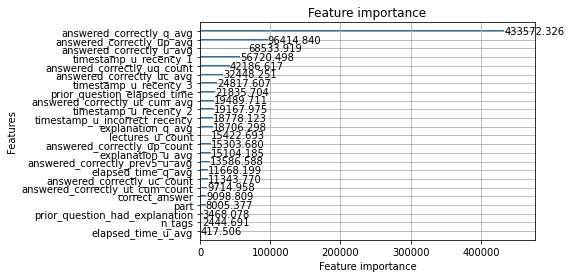

In [7]:
final_params = {}

final_params['models'] = {
    1 : {'model_name' : 'final_model_1'
        ,'dont_include' : ['prior_question_had_explanation', 'elapsed_time_u_avg', 'community', 'n_tags'
                           ,'answered_correctly_prev10_u_avg', 'cond_uq_prob']}
    
    ,2 : {'model_name' : 'final_model_2'
        ,'dont_include' : ['prior_question_had_explanation', 'community', 'n_tags'
                           ,'answered_correctly_prev10_u_avg', 'cond_uq_prob']}
    
    ,3 : {'model_name' : 'final_model_3'
        ,'dont_include' : ['prior_question_had_explanation', 'n_tags'
                           ,'answered_correctly_prev10_u_avg', 'cond_uq_prob']}
    
    ,4 : {'model_name' : 'final_model_4'
        ,'dont_include' : ['community', 'tag_1', 'tag_2', 'tag_3'
                          ,'answered_correctly_prev10_u_avg', 'cond_uq_prob']}
    
    ,5 : {'model_name' : 'final_model_5'
        ,'dont_include' : ['community', 'tag_1', 'tag_2', 'tag_3'
                          ,'prior_question_had_explanation', 'n_tags', 'answered_correctly_ut_cum_avg'
                          ,'timestamp_u_recency_2','timestamp_u_recency_3']}
    
    ,6 : {'model_name' : 'final_model_6'
        ,'dont_include' : ['community', 'tag_1', 'tag_2', 'tag_3'
                          ,'prior_question_had_explanation', 'n_tags', 'answered_correctly_ut_cum_count'
                          ,'timestamp_u_recency_3', 'answered_correctly_prev5_u_avg']}
    
    ,7 : {'model_name' : 'final_model_7'
        ,'dont_include' : ['community', 'tag_1', 'tag_2', 'tag_3'
                          ,'elapsed_time_u_avg', 'prior_question_had_explanation'
                          ,'n_tags', 'answered_correctly_ut_cum_avg'
                          ,'answered_correctly_prev5_u_avg']}
}

# *** Change these
# MAX_BIN ???????
final_params['models_to_use'] = [4]
final_params['N_TRAIN_ROWS'] = 1 * 1000000
final_params['num_boost_round'] = 10000
final_params['learning_rate'] = .1
final_params['kaggle_model_path'] = '/kaggle/input/finalmodels/'
final_params['n_kaggle_loops'] = 11

# Define number of rows to skip when reading train (hacky)
n_skip_rows = [0, 10, 20, 30, 40, 5, 15, 25, 35, 45]
for i in range(len(n_skip_rows)):
    n_skip_rows[i] *= 1000000
    
if not KAGGLE_RUN:
    for i in final_params['models_to_use']:
        # Set seeds
        random.seed(i)
        np.random.seed(i)
        os.environ['PYTHONHASHSEED'] = str(i)
        
        # Set final parameters
        final_params['seed'] = i
        final_params['model_name'] = final_params['models'][i]['model_name']
        final_params['dont_include'] = final_params['models'][i]['dont_include']
        final_params['num_leaves'] = np.random.randint(180, 250)
        final_params['feature_fraction'] = round(np.random.uniform(.75,.9), 2)
        final_params['bagging_fraction'] = round(np.random.uniform(.75,.9), 2)
        final_params['bagging_freq'] = np.random.randint(5, 20)
        final_params['min_data_in_leaf'] = np.random.randint(15,50)
        final_params['max_depth'] = np.random.randint(10, 50)
        final_params['early_stopping_rounds'] = np.random.randint(25, 60)
        final_params['n_skip_rows'] = n_skip_rows[i]
        
        # Run
        print('\n- - - - - - - - - - - - - - - - - - - - - - - -')
        print('Starting run: ' + str(i))
        print('Parameters:\n')
        print(json.dumps(final_params, sort_keys=True, indent=4))
        print('- - - - - - - - - - - - - - - - - - - - - - - -\n')
        
        # Read and preprocess
        s = time.time()
        train, valid, questions_df, features_dicts = read_and_preprocess(KAGGLE_RUN, final_params)
        print('Read and preprocess time: ' + str(round(time.time() - s, 2)))

        # Train
        del features_dicts
        gc.collect()
        train_and_evaluate(train, valid, KAGGLE_RUN, final_params)
        
        # Clean up before starting next
        del train, valid, questions_df
        gc.collect()
        
else:
    # - - - - Do feature engineering only once, then save the results
    f_path = '/kaggle/input/finalmodels/features_dicts_no_cond.dill'
    if not os.path.isfile(f_path):
        print("Running read_and_preprocess")
        train, valid, questions_df, features_dicts = read_and_preprocess(KAGGLE_RUN, final_params)
        with open('features_dicts_no_cond.dill', "wb") as dill_file:
            dill.dump(features_dicts, dill_file) 
    else:
        print("Will used cached feature_dicts")
        with open(f_path, 'rb') as handle:
            features_dicts = dill.load(handle)        
            
    # - - - - Get questions
    questions_df = get_questions(KAGGLE_RUN)
            
    # - - - - Get models and infer
    print('Getting Models')
    TARGET, FEATURES, models = train_and_evaluate(train, valid, KAGGLE_RUN, final_params)
    print('Inferring')
    inference(TARGET, FEATURES, models, questions_df, features_dicts, final_params)